# **Luis Arraez - 2022 vs 2023 season**


Vertical Approach Angle calculation (VAA):

**vy_f** = -sqrt(vy0² – (2 * ay * (y0 – yf))), 
**t** = (vy_f – vy0) / ay, 
**vz_f** = vz0 + (az * t), 
**VAA** = -arctan(vz_f/vy_f) * (180 / pi)

----

### **Statcast** ([CSV Documentation](https://baseballsavant.mlb.com/csv-docs))

- vy0 = The velocity of the pitch, in feet per second, in y-dimension*, determined at y=50 feet. (*toward home plate)
- ay = The acceleration of the pitch, in feet per second per second, in y-dimension, determined at y=50 feet.
- y0 = 50 (“y=50 feet”).
- yf = 17/12 (home plate, converted to inches).
- vz0 = The velocity of the pitch, in feet per second, in z-dimension**, determined at y=50 feet. (**vertically)
- az = The acceleration of the pitch, in feet per second per second, in z-dimension, determined at y=50 feet.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table
import seaborn as sns
import numpy as np
from math import sqrt, atan, degrees

# **2022 season**

In [2]:
mlb_2022 = pd.read_csv('arraez-2022.csv')
mlb_2022['pitch_name'] = mlb_2022['pitch_name'].str.replace('4-Seam Fastball', 'Four-Seam')


#def gravity_adjustment(speed):
    #return (523 / speed) ** 2

#def calculate_ivb(pfx_z_inches, release_speed):
    # Calcular el ajuste por gravedad en pulgadas
    #gravity_adjustment_inches = gravity_adjustment(release_speed)
    # Calcular el movimiento vertical inducido (iVB)
    #ivb = gravity_adjustment_inches - pfx_z_inches 
    #return ivb

#mlb_2022['ivb'] = mlb_2022.apply(lambda row: calculate_ivb(row['pfx_z_inches'], row['release_speed']), axis=1)

# Guardar el DataFrame actualizado en un nuevo archivo CSV
#mlb_2022.to_csv('your_file_with_ivb.csv', index=False)

# Mostrar el DataFrame actualizado
mlb_2022.head()



,pitch_name,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,count,pfx_z_inches,pfx_x_inches
0,Four-Seam,2022-10-05,91.9,-1.79,6.39,"Arraez, Luis",650333,663436,walk,ball,...,Standard,Standard,207,-0.007,0.245,NaN,NaN,3-1,15.12,2.16
1,Changeup,2022-10-05,86.3,-2.16,6.20,"Arraez, Luis",650333,663436,NaN,ball,...,Standard,Standard,231,0.000,0.114,NaN,NaN,2-1,8.16,11.40
2,Four-Seam,2022-10-05,91.6,-1.74,6.38,"Arraez, Luis",650333,663436,NaN,called_strike,...,Standard,Standard,212,0.000,-0.056,NaN,NaN,2-0,14.16,5.16
3,Four-Seam,2022-10-05,92.7,-1.60,6.39,"Arraez, Luis",650333,663436,NaN,ball,...,Standard,Standard,206,0.000,0.063,NaN,NaN,1-0,14.88,5.28
4,Curveball,2022-10-05,76.6,-1.73,6.56,"Arraez, Luis",650333,663436,NaN,ball,...,Standard,Standard,29,0.000,0.033,NaN,NaN,0-0,-14.76,-7.56


In [3]:
conditions = [
    (mlb_2022['launch_angle'] >= -90) & (mlb_2022['launch_angle'] <= 0),
    (mlb_2022['launch_angle'] >= 1) & (mlb_2022['launch_angle'] <= 7),
    (mlb_2022['launch_angle'] >= 8) & (mlb_2022['launch_angle'] <= 32),
    (mlb_2022['launch_angle'] >= 33) & (mlb_2022['launch_angle'] <= 39),
    (mlb_2022['launch_angle'] >= 40) & (mlb_2022['launch_angle'] <= 90)
]
choices = ['Topped', 'Burner', 'Sweet Spot', 'Flare', 'Under']

mlb_2022['launch_category'] = pd.cut(
    mlb_2022['launch_angle'],
    bins=[-91, 0, 7, 32, 39, 90],
    labels=['Topped', 'Burner', 'Sweet Spot', 'Flare', 'Under']
)

# Verificar los resultados
print(mlb_2022[['launch_angle', 'launch_category']].head())


   launch_angle launch_category
0           NaN             NaN
1           NaN             NaN
2           NaN             NaN
3           NaN             NaN
4           NaN             NaN


In [4]:
fastballs = ['Four-Seam', 'Sinker', 'Cutter']
breaking_balls = ['Curveball', 'Knuckle Curve', 'Slider', 'Sweeper', 'Slurve', 'Knuckleball']
offspeed_balls = ['Changeup', 'Split-Finger', 'Forkball', 'Screwball']

mlb_2022['pitch_type_group'] = np.where(mlb_2022['pitch_name'].isin(fastballs), 'Fastballs', 
                                    np.where(mlb_2022['pitch_name'].isin(breaking_balls), 'Breaking ball', 
                                             np.where(mlb_2022['pitch_name'].isin(offspeed_balls), 'Offspeed', 'Other')))

# Filtrar los lanzamientos no categorizados
data = mlb_2022[mlb_2022['pitch_type_group'] != 'Other']

pitch_count_by_type = data['pitch_type_group'].value_counts()
# Mostrar los resultados
print(pitch_count_by_type)

pitch_type_group
Fastballs        1484
Breaking ball     586
Offspeed          304
Name: count, dtype: int64


In [5]:
offspeed_balls_data = mlb_2022[mlb_2022['pitch_name'].isin(offspeed_balls)]
#fastballs_data['pfx_z_inches'] = fastballs_data['pfx_z'] * 12
#fastballs_data['pfx_x_inches'] = fastballs_data['pfx_x'] * -12



# Definir la posición vertical final en pulgadas
yf_inches = 17 / 12  # Convertir a pulgadas (1 pie = 12 pulgadas)

# Calcular el ángulo de aproximación vertical (VAA) para cada fila en el DataFrame
def calcular_vaa(row):
    vy0 = row['vy0']  # Velocidad vertical inicial
    vz0 = row['vz0']  # Velocidad vertical inicial
    ay = row['ay']  # Aceleración vertical
    az = row['az']  # Aceleración vertical
    vy_f = -sqrt(vy0**2 - 2 * ay * (50 - yf_inches))  # Velocidad vertical final
    t = (vy_f - vy0) / ay  # Tiempo de vuelo
    vz_f = vz0 + (az * t)  # Velocidad vertical final
    VAA = -degrees(atan(vz_f / vy_f))  # Ángulo de aproximación vertical en grados
    return VAA

def calcular_haa(row):
    vx0 = row['vx0']  # Velocidad horizontal inicial
    vy0 = row['vy0']  # Velocidad vertical inicial
    ax = row['ax']  # Aceleración horizontal
    ay = row['ay']  # Aceleración vertical
    vy_f = -sqrt(vy0**2 - 2 * ay * (50 - yf_inches))  # Velocidad vertical final (ya calculada en VAA)
    t = (vy_f - vy0) / ay  # Tiempo de vuelo (ya calculado en VAA)
    vx_f = vx0 + (ax * t)  # Velocidad horizontal final
    HAA = -degrees(atan(vx_f / vy_f))  # Ángulo de aproximación horizontal en grados
    return HAA

# Aplicar la función calcular_vaa a cada fila del DataFrame
offspeed_balls_data['Vertical Approach Angle'] = offspeed_balls_data.apply(calcular_vaa, axis=1)
offspeed_balls_data['Horizontal Approach Angle'] = offspeed_balls_data.apply(calcular_haa, axis=1)
# Mostrar los resultados agrupados por tipo de lanzamiento
print("Resumen de Vertical Approach Angle para cada tipo de Fastball:")
print(offspeed_balls_data.groupby('pitch_name')['Vertical Approach Angle'].mean())

Resumen de Vertical Approach Angle para cada tipo de Fastball:
pitch_name
Changeup   -7.362089
Name: Vertical Approach Angle, dtype: float64


C:\Users\sedem\AppData\Local\Temp\ipykernel_16100\2327129559.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offspeed_balls_data['Vertical Approach Angle'] = offspeed_balls_data.apply(calcular_vaa, axis=1)
C:\Users\sedem\AppData\Local\Temp\ipykernel_16100\2327129559.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offspeed_balls_data['Horizontal Approach Angle'] = offspeed_balls_data.apply(calcular_haa, axis=1)


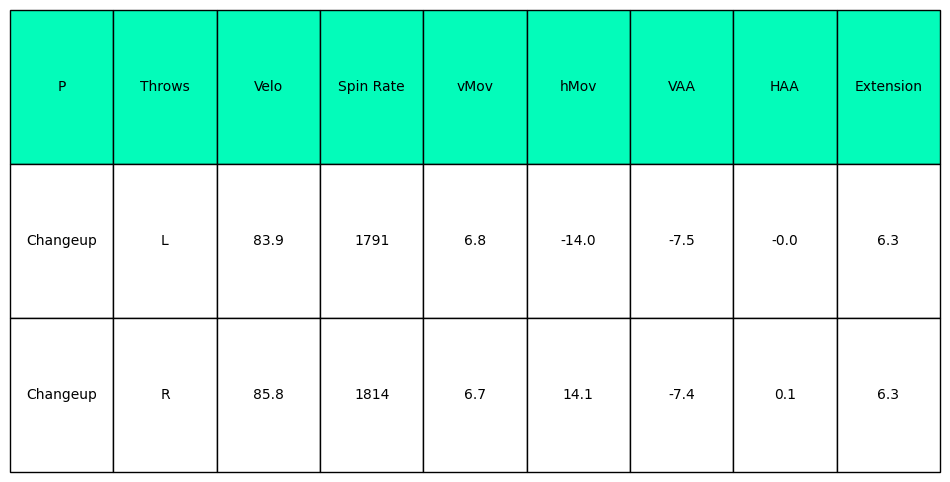

In [6]:

summary_table = offspeed_balls_data.groupby(['pitch_name', 'p_throws']).agg({
    'release_speed': lambda x: round(np.mean(x), 1),
    'release_spin_rate': lambda x: int(np.mean(x)),
    'pfx_z_inches': lambda x: round(np.mean(x), 1),
    'pfx_x_inches': lambda x: round(np.mean(x), 1),
    #'spin_axis': lambda x: round(np.mean(x), 1),
    'Vertical Approach Angle': lambda x: round(np.mean(x), 1),
    'Horizontal Approach Angle': lambda x: round(np.mean(x), 1),
    #'effective_speed': lambda x: round(np.mean(x), 1),
    'release_extension': lambda x: round(np.mean(x), 1)
}).reset_index()

summary_table.columns = ['P', 'Throws', 'Velo', 'Spin Rate', 'vMov', 'hMov', 'VAA', 'HAA' , 'Extension']

fig, ax = plt.subplots(figsize=(12, 6))  # Ajustar el tamaño de la imagen según sea necesario
ax.axis('off')

# Crear una tabla en matplotlib
tbl = Table(ax, bbox=[0, 0, 1, 1])

# Añadir las cabeceras
ncols = summary_table.shape[1]
nrows = summary_table.shape[0] + 1

# Ajustar el tamaño de las celdas
width, height = 50 / ncols, 1.0 / nrows

fontsize = 45
fontweight = 'bold'

# Añadir las cabeceras
for i, column in enumerate(summary_table.columns):
    tbl.add_cell(0, i, width, height, text=column, loc='center', facecolor='#03fcba')

# Añadir las filas
for row_idx, row in summary_table.iterrows():
    for col_idx, value in enumerate(row):
        tbl.add_cell(row_idx + 1, col_idx, width, height, text=value, loc='center', facecolor='white')

ax.add_table(tbl)

# Guardar la imagen
#plt.savefig('/mnt/data/summary_table.png', bbox_inches='tight', dpi=300)

# Mostrar la imagen
plt.show()

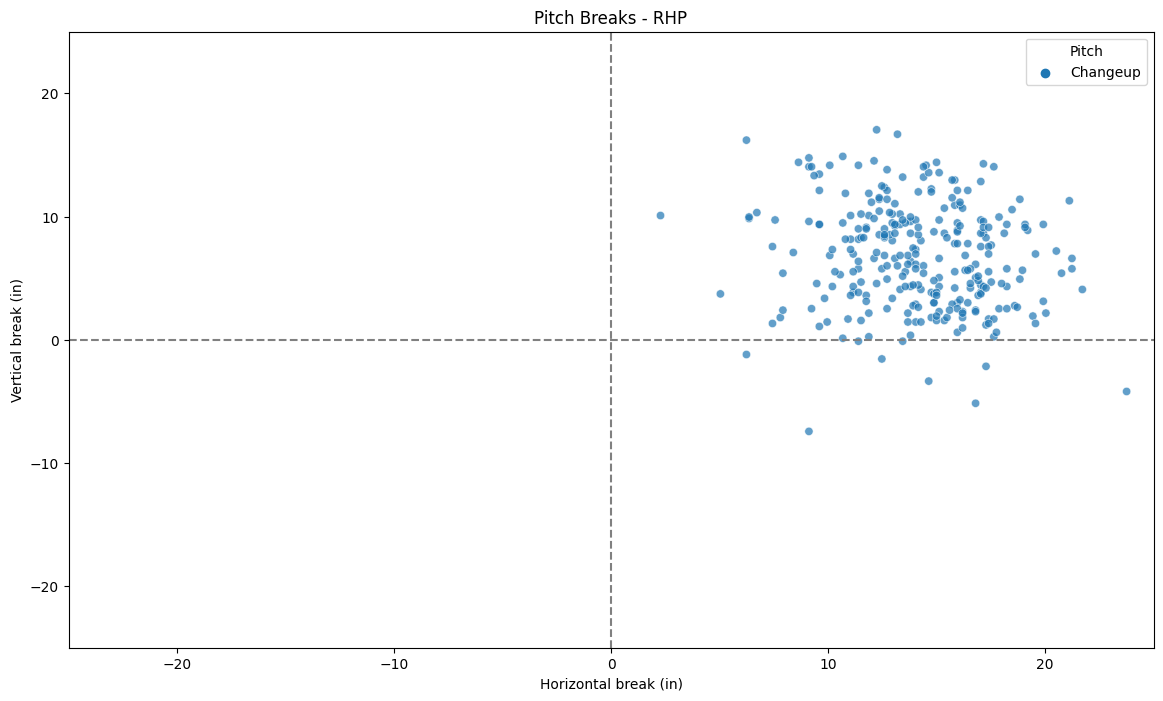

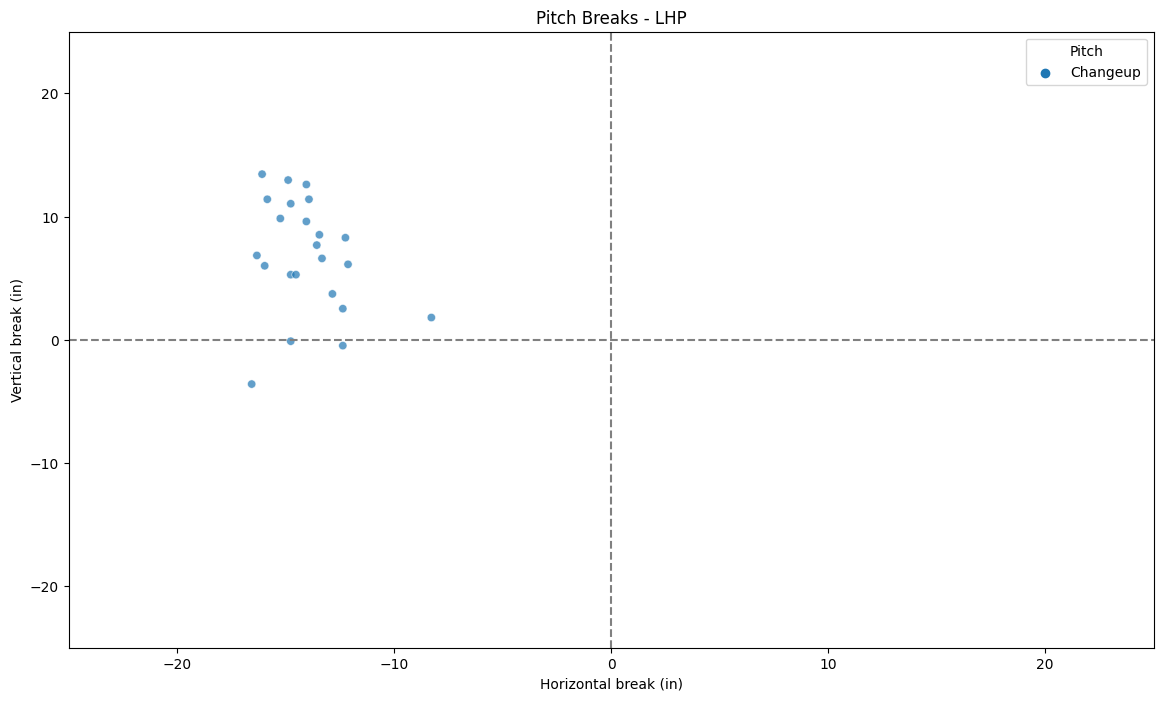

In [7]:

# Separar los datos por lanzadores diestros (R) y zurdos (L)
offspeed_balls_data_R = offspeed_balls_data[offspeed_balls_data['p_throws'] == 'R']
offspeed_balls_data_L = offspeed_balls_data[offspeed_balls_data['p_throws'] == 'L']

# Colores vivos para los tipos de lanzamiento
#pitch_palette = {'Four-Seam': 'red', 'Sinker': 'blue', 'Cutter': 'green'}

# Graficar para lanzadores diestros (R)
plt.figure(figsize=(14, 8))
sns.scatterplot(data=offspeed_balls_data_R, x='pfx_x_inches', y='pfx_z_inches', hue='pitch_name', alpha=0.7)
plt.title('Pitch Breaks - RHP')
plt.xlabel('Horizontal break (in)')
plt.ylabel('Vertical break (in)')
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.xlim(-25, 25)  # Establecer límites personalizados para el eje x
plt.ylim(-25, 25)  # Establecer límites personalizados para el eje y
plt.legend(title='Pitch')
plt.show()

# Graficar para lanzadores zurdos (L)
plt.figure(figsize=(14, 8))
sns.scatterplot(data=offspeed_balls_data_L, x='pfx_x_inches', y='pfx_z_inches', hue='pitch_name', alpha=0.7)
plt.title('Pitch Breaks - LHP')
plt.xlabel('Horizontal break (in)')
plt.ylabel('Vertical break (in)')
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.xlim(-25, 25)  # Establecer límites personalizados para el eje x
plt.ylim(-25, 25)  # Establecer límites personalizados para el eje y
plt.legend(title='Pitch')
plt.show()

In [8]:
def draw_sz(sz_top=3.5, sz_bot=1.5, ls='k-'):
  """
  draw strike zone  
  draw the strike zone on a plot using mpl  
  inputs:
    sz_top: top of strike zone (ft) 
    sz_bot: bottom of strike zone (ft) 
    ls: linestyle (use `plt.plot()` linestyle conventions)  
  output:
    strike zone plot
  """
  plt.plot([-0.708, 0.708], [sz_bot,sz_bot], ls)
  plt.plot([-0.708, -0.708], [sz_bot,sz_top], ls)
  plt.plot([0.708, 0.708], [sz_bot,sz_top], ls)
  plt.plot([-0.708, 0.708], [sz_top,sz_top], ls) 

def draw_home_plate(catcher_perspective=True, ls='k-'):
  """
  draw home plate from either the catcher perspective or pitcher perspective  
  inputs: 
    catcher_perspective: orient home plate in the catcher POV. if False, orients
      home plate in the pitcher POV.  
    ls: linestyle (use `plt.plot()` linestyle conventions)  
  output:
    home plate plot
  """
  if catcher_perspective:
    plt.plot([-0.708, 0.708], [0,0], ls)
    plt.plot([-0.708, -0.708], [0,-0.3], ls)
    plt.plot([0.708, 0.708], [0,-0.3], ls)
    plt.plot([-0.708, 0], [-0.3, -0.6], ls)
    plt.plot([0.708, 0], [-0.3, -0.6], ls)
  else: 
    plt.plot([-0.708, 0.708], [0,0], ls)
    plt.plot([-0.708, -0.708], [0,0.1], ls)
    plt.plot([0.708, 0.708], [0,0.1], ls)
    plt.plot([-0.708, 0], [0.1, 0.3], ls)
    plt.plot([0.708, 0], [0.1, 0.3], ls)

def draw_attack_zones():
  """
  draw attack zones 
  draw the statcast attack zones on a plot using mpl  
  """

  # outer heart / inner shadow
  plt.plot([-0.558, 0.558], [1.833,1.833], color=(227/255, 150/255, 255/255), ls='-', lw=3)
  plt.plot([-0.558, -0.558], [1.833,3.166], color=(227/255, 150/255, 255/255), ls='-', lw=3)
  plt.plot([0.558, 0.558], [1.833,3.166], color=(227/255, 150/255, 255/255), ls='-', lw=3)
  plt.plot([-0.558, 0.558], [3.166,3.166], color=(227/255, 150/255, 255/255), ls='-', lw=3) 

  # outer shadow /  inner chase 
  plt.plot([-1.108, 1.108], [1.166,1.166], color=(255/255, 197/255, 150/255), ls='-', lw=3)
  plt.plot([-1.108, -1.108], [1.166,3.833], color=(255/255, 197/255, 150/255), ls='-', lw=3)
  plt.plot([1.108, 1.108], [1.166,3.833], color=(255/255, 197/255, 150/255), ls='-', lw=3)
  plt.plot([-1.108, 1.108], [3.833,3.833], color=(255/255, 197/255, 150/255), ls='-', lw=3) 

  # outer chase 
  plt.plot([-1.666, 1.666], [0.5,0.5], color=(209/255, 209/255, 209/255), ls='-', lw=3)
  plt.plot([-1.666, -1.666], [0.5,4.5], color=(209/255, 209/255, 209/255), ls='-', lw=3)
  plt.plot([1.666, 1.666], [0.5,4.5], color=(209/255, 209/255, 209/255), ls='-', lw=3)
  plt.plot([-1.666, 1.666], [4.5,4.5], color=(209/255, 209/255, 209/255), ls='-', lw=3)

C:\Users\sedem\AppData\Local\Temp\ipykernel_16100\371426495.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offspeed_balls_data['attack_zone'] = 'Waste'


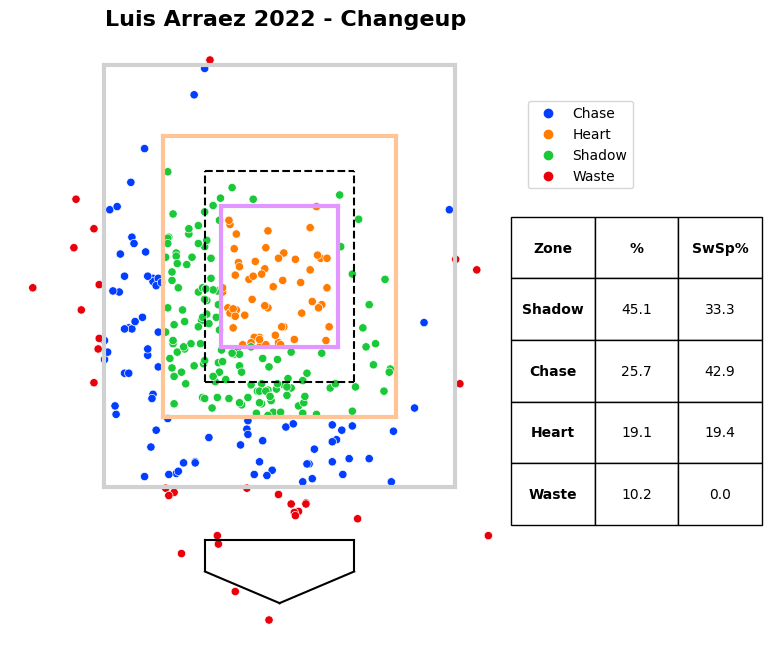

In [9]:
offspeed_balls_data = mlb_2022[mlb_2022['pitch_name'].isin(offspeed_balls)]

offspeed_balls_data['attack_zone'] = 'Waste'
offspeed_balls_data.loc[(offspeed_balls_data['plate_x'].between(-0.558, 0.558)) & (offspeed_balls_data['plate_z'].between(1.833,3.166)), 'attack_zone'] = 'Heart'
offspeed_balls_data.loc[(offspeed_balls_data['plate_x'].between(-1.108, 1.108)) & (offspeed_balls_data['plate_z'].between(1.166,3.833)) & (~offspeed_balls_data['attack_zone'].isin(['Heart'])), 'attack_zone'] = 'Shadow'
offspeed_balls_data.loc[(offspeed_balls_data['plate_x'].between(-1.666, 1.666)) & (offspeed_balls_data['plate_z'].between(0.5,4.5)) & (~offspeed_balls_data['attack_zone'].isin(['Heart', 'Shadow'])), 'attack_zone'] = 'Chase'

zone_counts = offspeed_balls_data['attack_zone'].value_counts(normalize=True) * 100
zone_percentages = zone_counts.reset_index()
zone_percentages.columns = ['Zone', '%']

# Calcular el porcentaje de Sweet Spot en cada zona
percentage_table = pd.crosstab(offspeed_balls_data['attack_zone'], offspeed_balls_data['launch_category'], normalize='index') * 100

# Extraer los porcentajes de Sweet Spot para cada zona
zones = ['Heart', 'Shadow', 'Chase', 'Waste']
sweet_spot_percentages = percentage_table['Sweet Spot'].reindex(zones, fill_value=0).reset_index()
sweet_spot_percentages.columns = ['Zone', 'SwSp%']

# Combinar los porcentajes en una sola tabla
combined_percentages = pd.merge(zone_percentages, sweet_spot_percentages, on='Zone')

# Formatear los valores para mostrar solo un decimal
combined_percentages['%'] = combined_percentages['%'].map('{:.1f}'.format)
combined_percentages['SwSp%'] = combined_percentages['SwSp%'].map('{:.1f}'.format)


fig = plt.figure(figsize=(8,8))
fig = sns.scatterplot(data=offspeed_balls_data, x='plate_x', y='plate_z', 
                      hue='attack_zone', palette='bright')
draw_sz(ls='k--')
draw_home_plate()
draw_attack_zones()
fig.set_aspect('equal')
plt.legend(bbox_to_anchor=(1.02,0.90), loc=2)
plt.title('Luis Arraez 2022 - Changeup', fontsize=16, loc='center', pad=5, y=1, x=0.55, weight='bold')
plt.xlabel('')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

table = plt.table(cellText=combined_percentages.values,
                  colLabels=combined_percentages.columns,
                  cellLoc='center',
                  bbox=(1, .2, 0.5, 0.5))

table.auto_set_font_size(False)
table.set_fontsize(10)  # Ajusta este valor según sea necesario

for key, cell in table.get_celld().items():
    if key[0] == 0 or key[1] == 0:
        cell.set_text_props(weight='bold')
                 

plt.show()

In [10]:
percentage_table = pd.crosstab(offspeed_balls_data['attack_zone'], offspeed_balls_data['launch_category'], normalize='index') * 100

# Mostrar los porcentajes con un decimal
percentage_table = percentage_table.applymap('{:.1f}'.format)

# Ver los resultados
print(percentage_table)

launch_category Topped Burner Sweet Spot Flare Under
attack_zone                                         
Chase             35.7    0.0       42.9   0.0  21.4
Heart             30.6   11.1       19.4  13.9  25.0
Shadow            32.1    7.4       33.3   4.9  22.2
Waste              0.0  100.0        0.0   0.0   0.0
